## Importing functions

In [13]:
import os
import pandas as pd
import zipfile
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from rapidfuzz import fuzz, process
import folium
from scipy import stats
import requests

# Functions to load the data

In [3]:
data_folder = "data"

# 1. Load bus routes data from CSV file
def load_bus_routes_data():
    bus_routes_path = os.path.join(data_folder, "bus_routes_data.csv")
    if os.path.exists(bus_routes_path):
        bus_routes_df = pd.read_csv(bus_routes_path)
        return bus_routes_df
    else:
        print(f"Error: {bus_routes_path} not found.")
        return None

# 2. Load bus stops data from CSV file and convert to GeoDataFrame
def load_bus_stops_data():
    bus_stops_path = os.path.join(data_folder, "bus_stops_data.csv")
    if os.path.exists(bus_stops_path):
        bus_stops_df = pd.read_csv(bus_stops_path)
        # Create a GeoDataFrame for bus stops with Point geometries from Longitude and Latitude
        bus_stops_gdf = gpd.GeoDataFrame(
            bus_stops_df,
            geometry=gpd.points_from_xy(bus_stops_df['Longitude'], bus_stops_df['Latitude']),
            crs='EPSG:4326'
        )
        print("Bus Stops Data Loaded and converted to GeoDataFrame.")
        return bus_stops_gdf
    else:
        print(f"Error: {bus_stops_path} not found.")
        return None

# 3. Load Passenger Volume by Bus Stops data from ZIP file
def load_passenger_volume_bus_stops():
    zip_path = os.path.join(data_folder, "transport_node_bus_202408.zip")
    csv_file_name = "transport_node_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                passenger_volume_df = pd.read_csv(csv_file)
                print("Passenger Volume by Bus Stops Data Loaded.")
                return passenger_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None

# 4. Load Origin-Destination Bus Stops data from ZIP file
def load_od_volume_bus_stops():
    zip_path = os.path.join(data_folder, "origin_destination_bus_202408.zip")
    csv_file_name = "origin_destination_bus_202408.csv"
    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as z:
            with z.open(csv_file_name) as csv_file:
                od_volume_df = pd.read_csv(csv_file)
                print("Origin-Destination Bus Stops Data Loaded.")
                return od_volume_df
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 5. Load MRT exits data from ZIP file
def load_mrt_exits_shapefile():
    zip_path = os.path.join('data', "train_station_exit_geospatial_whole_island_202408.zip")
    shapefile_components = [
        'TrainStationExit/Train_Station_Exit_Layer.shp',
        'TrainStationExit/Train_Station_Exit_Layer.dbf',
        'TrainStationExit/Train_Station_Exit_Layer.shx'
    ]

    if os.path.exists(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                        
            temp_dir = 'temp_shapefile'  # Temporary folder for extraction
            os.makedirs(temp_dir, exist_ok=True)
            
            # Extract necessary shapefile components
            for component in shapefile_components:
                zip_ref.extract(component, path=temp_dir)

            # Load the shapefile into a GeoDataFrame
            shapefile_path = os.path.join(temp_dir, 'TrainStationExit', 'Train_Station_Exit_Layer.shp')
            gdf_exits = gpd.read_file(shapefile_path)

            # Clean up extracted files and temporary directory
            for component in shapefile_components:
                os.remove(os.path.join(temp_dir, component))
            
            # Remove the empty directory
            try:
                os.rmdir(os.path.join(temp_dir, 'TrainStationExit'))
                os.rmdir(temp_dir)
            except OSError as e:
                print(f"Warning: {e.strerror} - {e.filename}")
            
            print("MRT Exits data loaded.")
            
            # Display the columns (fields) and first few rows in the shapefile
            print("Columns in MRT Exits Shapefile:")
            print(gdf_exits.columns)
            print("\nFirst 5 rows of data:")
            print(gdf_exits.head())
            
            return gdf_exits
    else:
        print(f"Error: {zip_path} not found.")
        return None
    
# 6. Load mrtlines data
def load_mrt_lines_mapping():
    mrt_lines_path = os.path.join(data_folder, "singapore_mrt_stations_with_lines_filtered.csv")
    if os.path.exists(mrt_lines_path):
        mrt_lines_df = pd.read_csv(mrt_lines_path)
        return mrt_lines_df
    else:
        print(f"Error: {mrt_lines_path} not found.")
    

## Loading the Data

In [4]:
# Load datasets
bus_routes_df = load_bus_routes_data()
bus_stops_gdf = load_bus_stops_data()
passenger_volume_df = load_passenger_volume_bus_stops()
od_volume_df = load_od_volume_bus_stops()
mrt_exits_gdf = load_mrt_exits_shapefile()
mrt_lines_mapping = load_mrt_lines_mapping()

# Ensure that the data is being loaded correctly
if bus_routes_df is not None:
    print(f"Bus Routes DataFrame shape: {bus_routes_df.shape}")
if bus_stops_gdf is not None:
    print(f"Bus Stops GeoDataFrame shape: {bus_stops_gdf.shape}")
if passenger_volume_df is not None:
    print(f"Passenger Volume DataFrame shape: {passenger_volume_df.shape}")
if od_volume_df is not None:
    print(f"Origin-Destination Bus Stops DataFrame shape: {od_volume_df.shape}")
if mrt_exits_gdf is not None:
    print(f"MRT Exits GeoDataFrame shape: {mrt_exits_gdf.shape}")
if mrt_lines_mapping is not None:
    print(f"MRT Lines Mapping DataFrame shape: {mrt_lines_mapping.shape}")
    
bus_routes_df

Bus Stops Data Loaded and converted to GeoDataFrame.
Passenger Volume by Bus Stops Data Loaded.
Origin-Destination Bus Stops Data Loaded.
MRT Exits data loaded.
Columns in MRT Exits Shapefile:
Index(['stn_name', 'exit_code', 'geometry'], dtype='object')

First 5 rows of data:
                 stn_name exit_code                     geometry
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)
1  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)
2  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)
3    TONGKANG LRT STATION    Exit B  POINT (33872.145 41256.053)
4    TONGKANG LRT STATION    Exit A  POINT (33858.542 41234.065)
Bus Routes DataFrame shape: (25500, 12)
Bus Stops GeoDataFrame shape: (5137, 6)
Passenger Volume DataFrame shape: (199800, 7)
Origin-Destination Bus Stops DataFrame shape: (5760081, 7)
MRT Exits GeoDataFrame shape: (593, 3)
MRT Lines Mapping DataFrame shape: (186, 10)


,ServiceNo,Operator,Direction,StopSequence,BusStopCode,Distance,WD_FirstBus,WD_LastBus,SAT_FirstBus,SAT_LastBus,SUN_FirstBus,SUN_LastBus
0,10,SBST,1,1,75009,0.0,0500,2300,0500,2300,0500,2300
1,10,SBST,1,2,76059,0.6,0502,2302,0502,2302,0502,2302
2,10,SBST,1,3,76069,1.1,0504,2304,0504,2304,0503,2304
3,10,SBST,1,4,96289,2.3,0508,2308,0508,2309,0507,2308
4,10,SBST,1,5,96109,2.7,0509,2310,0509,2311,0508,2309
...,...,...,...,...,...,...,...,...,...,...,...,...
25495,9B,SBST,1,25,95091,9.5,0741,0817,-,-,-,-
25496,9B,SBST,1,26,95131,9.7,0742,0818,-,-,-,-
25497,9B,SBST,1,27,95141,10.2,0744,0820,-,-,-,-
25498,9B,SBST,1,28,95061,10.6,0745,0821,-,-,-,-


## Tagging bus stops to MRT Exit
We need to identify the bus stops that are linked to the MRT exits. There are 2 main ways to approach this:
1. String matching based on description
   1. We attempted this method and found that while it worked for most of the stations, it still caught on to alot of false positives. One false positive example is 'Carltex Stn', which is not a train station.
2. Distance matching based on MRT exits

## Tagging MRT Exits to MRT Stations
We will now determine which MRT station and MRT line does each exit belong to. We need to note that they may not always contain the exact match of the MRT station name. So we will use a fuzzy matching approach to find the closest match

Filter out the words MRT Station
If there is LRT, also filter out the whole thing

In [5]:
# Function to filter out "LRT", remove "MRT STATION", fuzzy match, and join MRT lines, then drop unwanted columns
def match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf, threshold=50):
    # Step 1: Filter out rows containing "LRT" in the station name
    mrt_exits_gdf = mrt_exits_gdf[~mrt_exits_gdf['stn_name'].str.contains('LRT', case=False)]
    
    # Step 2: Remove "MRT STATION" from 'stn_name' before matching
    mrt_exits_gdf['stn_name_cleaned'] = mrt_exits_gdf['stn_name'].str.replace('MRT STATION', '', case=False).str.strip()

    # Step 3: Perform fuzzy matching and create a new column for the best matched station name
    # Get the MRT station names in lowercase for case-insensitive matching
    mrt_station_names = mrt_lines_mapping['Station name_English • Malay'].str.lower().tolist()
    
    matched_station_names = []  # List to store matched station names

    for idx, row in mrt_exits_gdf.iterrows():
        exit_description = row['stn_name_cleaned'].lower()  # Lowercase the cleaned station name for case-insensitive matching
        
        # Perform fuzzy matching to find the closest MRT station name
        match_result = process.extractOne(exit_description, mrt_station_names, scorer=fuzz.token_sort_ratio)
        
        if match_result:
            match, score, _ = match_result
            if score >= threshold:
                matched_station_names.append(match)
            else:
                matched_station_names.append(None)
        else:
            matched_station_names.append(None)
    
    # Add the matched station names to the GeoDataFrame as a new column
    mrt_exits_gdf['stn_name_matched'] = matched_station_names
    
    # Step 4: Perform a left join to the MRT lines mapping DataFrame
    # Standardize the MRT station names to lowercase for the merge
    mrt_lines_mapping['Station name_English • Malay'] = mrt_lines_mapping['Station name_English • Malay'].str.lower()

    # Left join based on the matched station names
    mrt_exits_gdf = mrt_exits_gdf.merge(mrt_lines_mapping, 
                                        left_on='stn_name_matched', 
                                        right_on='Station name_English • Malay', 
                                        how='left')

    # Step 5: Drop the unnecessary columns
    cols_to_drop = ['Matched_MRT_Line', 'stn_name_cleaned', 'MRT_Lines']
    mrt_exits_gdf.drop(columns=cols_to_drop, inplace=True, errors='ignore')

    return mrt_exits_gdf

# Example of calling the function
mrt_exits_gdf_mapped = match_mrt_line_to_exits(mrt_lines_mapping, mrt_exits_gdf)

# Display the updated DataFrame
print(mrt_exits_gdf_mapped.head())


                 stn_name exit_code                     geometry  \
0  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
1  MACPHERSON MRT STATION    Exit A  POINT (34285.068 34322.985)   
2  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
3  MACPHERSON MRT STATION    Exit B  POINT (34382.153 34231.904)   
4  MACPHERSON MRT STATION    Exit C  POINT (34337.292 34190.603)   

  stn_name_matched Station name_English • Malay  NS  EW  DT  CC  NE  TE  CG  \
0       macpherson                   macpherson   0   0   1   1   0   0   0   
1       macpherson                   macpherson   0   0   1   1   0   0   0   
2       macpherson                   macpherson   0   0   1   1   0   0   0   
3       macpherson                   macpherson   0   0   1   1   0   0   0   
4       macpherson                   macpherson   0   0   1   1   0   0   0   

   CE  
0   0  
1   0  
2   0  
3   0  
4   0  


/Users/zhanheng/Public/github/project/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/zhanheng/Public/github/project/.venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


##### Why remove LRT?
The function of a LRT is very different from the MRT. The current LRT system focuses on serving a small and concentrated area, such as the residential estate, whereas the MRT serves the entire Singapore. Given the small area that it runs, we believe that by inclduing the LRT for our route examination as the probability of it running the same route as our bus services is very high.

This will result in false positives - We will incorrectly flag bus routes as 'redundant'

### Optimal Distance
In reality, we believe that bus stops less than 1 MRT distance away from MRT stations are considered MRT Bus Stops. 

So to find the optimal distance, we check the bus routes to find the average distance between two bus stops, excluding the outliers.

Number of global outlier stops: 224


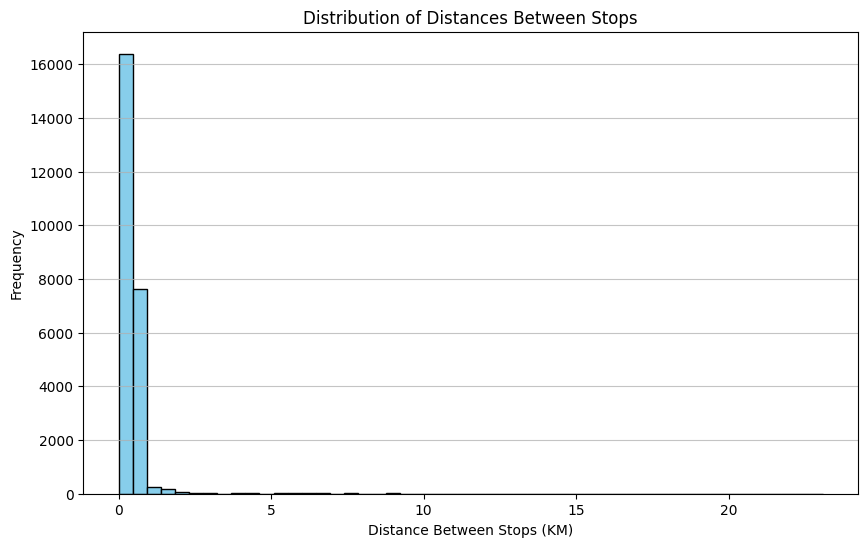

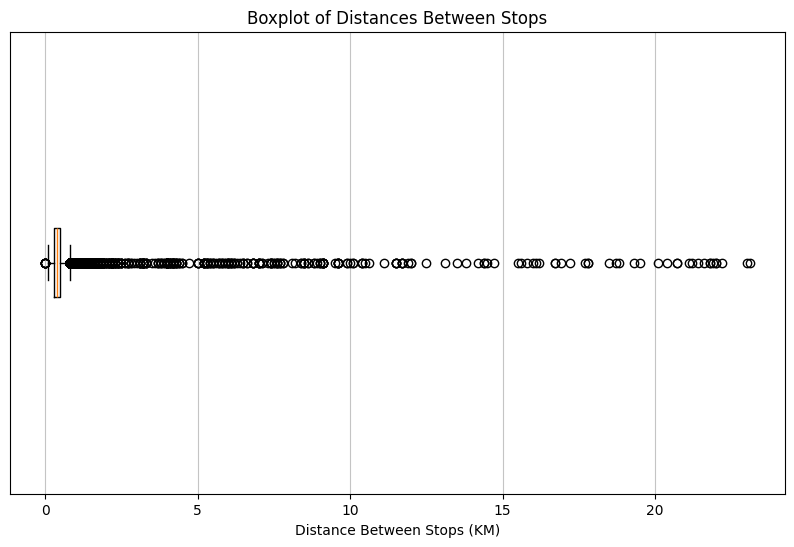

Average distance between stops: 0.51 km
Median distance between stops: 0.40 km
Average distance between stops after removing outliers: 0.43 km
Median distance between stops after removing outliers: 0.40 km


In [6]:
# Sort the data
bus_routes_df_sorted = bus_routes_df.sort_values(by=['ServiceNo', 'Direction', 'StopSequence'])

# Calculate the distance between stops
bus_routes_df_sorted['DistanceBetweenStops'] = bus_routes_df_sorted.groupby(['ServiceNo', 'Direction'])['Distance'].diff()

# Drop NaN values resulting from diff()
bus_routes_df_sorted = bus_routes_df_sorted.dropna(subset=['DistanceBetweenStops'])

# Calculate z-scores across all distances between stops
bus_routes_df_sorted['z_score_global'] = stats.zscore(bus_routes_df_sorted['DistanceBetweenStops'])

# Define a threshold for z-score to identify outliers
threshold = 3.5  # You can adjust this value

# Identify outliers
global_outliers = bus_routes_df_sorted[np.abs(bus_routes_df_sorted['z_score_global']) > threshold]

print("Number of global outlier stops:", global_outliers.shape[0])

# Plot out the distribution of distances between stops
plt.figure(figsize=(10, 6))
plt.hist(bus_routes_df_sorted['DistanceBetweenStops'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Distances Between Stops')
plt.xlabel('Distance Between Stops (KM)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Plot the boxplot of distances between stops
plt.figure(figsize=(10, 6))
plt.boxplot(bus_routes_df_sorted['DistanceBetweenStops'], vert=False)
plt.title('Boxplot of Distances Between Stops')
plt.xlabel('Distance Between Stops (KM)')
plt.yticks([])
plt.grid(axis='x', alpha=0.75)
plt.show()

# Average and median distance between stops
average_distance = bus_routes_df_sorted['DistanceBetweenStops'].mean()
median_distance = bus_routes_df_sorted['DistanceBetweenStops'].median()
print(f"Average distance between stops: {average_distance:.2f} km")
print(f"Median distance between stops: {median_distance:.2f} km")

# Distance after removing outliers
filtered_distance = bus_routes_df_sorted[np.abs(bus_routes_df_sorted['z_score_global']) <= threshold]['DistanceBetweenStops']
filtered_average_distance = filtered_distance.mean()
filtered_median_distance = filtered_distance.median()
print(f"Average distance between stops after removing outliers: {filtered_average_distance:.2f} km")
print(f"Median distance between stops after removing outliers: {filtered_median_distance:.2f} km")


So from above, even after removing the outliers, the median distance between stops is still ~400m. So now, we will be using 400m as the optimal distance

Using the optimal distance found, we can assume that bus stops within 1 MRT station can be tagged as a MRT bus stop. So presumably, if the bus stop is ~500m away from the MRT, technically we can assume that it is sufficiently close to walk to a MRT station.

In [8]:
optimal_distance = filtered_median_distance * 1000  # Convert to meters
print(f"Optimal distance between stops: {optimal_distance:.2f} m")
# Function to tag bus stops with MRT proximity and include MRT line indicators
def tagging_mrt_to_bus_stops(y, x, distance=optimal_distance):
    # Set CRS if not already defined
    if y.crs is None:
        y = y.set_crs(epsg=3414)  # Use SVY21 (Singapore)
    if x.crs is None:
        x = x.set_crs(epsg=3414)  # WGS84 for bus stops

    # Re-project MRT exits to EPSG:4326 (WGS84) to match bus stops
    y = y.to_crs(epsg=3414)

    projected_crs = "EPSG:3857"  # Mercator projection in meters
    y_projected = y.to_crs(projected_crs)
    x_projected = x.to_crs(projected_crs)

    # Perform a spatial join to find the nearest bus stop for each MRT exit
    nearest_bus_stops = gpd.sjoin_nearest(
        y_projected, 
        x_projected, 
        how="left", 
        distance_col="distance"  # Create a column for the distance between the points
    )
    
    # Filter based on the specified distance to ensure we're tagging bus stops correctly
    nearest_bus_stops_filtered = nearest_bus_stops[nearest_bus_stops['distance'] <= distance]

    # Tag bus stops that are within the specified distance as MRT-related
    x['is_mrt'] = x_projected.index.isin(nearest_bus_stops_filtered['index_right'])

    # Perform a normal left merge to bring in MRT line information and matched MRT station
    # We use `BusStopCode` and `index_right` to perform the merge
    merged = x.merge(nearest_bus_stops_filtered[['stn_name_matched', 'NS', 'EW', 'DT', 'CC', 'NE', 'TE', 'CG', 'CE', 'index_right', 'distance']],
                     left_index=True, right_on='index_right', 
                     how='left')

    merged = merged.rename(columns={
        'geometry_x': 'geometry_bus',
        'geometry_y': 'geometry_mrt'
    })
    
    # Filter out duplicate BusStopCode entries
    merged = merged.drop_duplicates(subset='BusStopCode')

    return merged

# Call the function with the MRT exits and bus stops GeoDataFrames
tagging = tagging_mrt_to_bus_stops(mrt_exits_gdf_mapped, bus_stops_gdf)

# Filter only the MRT-related bus stops
bus_stops_mrt = tagging[tagging['is_mrt'] == True]

print(bus_stops_mrt.head())
bus_stops_mrt

# Save the tagged bus stops to a csv
tagging.to_csv('data/tagged_bus_stops.csv', index=False)


Optimal distance between stops: 400.00 m
       BusStopCode     RoadName              Description  Latitude  \
277.0         1059  Victoria St         Bugis Stn Exit B  1.300757   
271.0         1112  Victoria St     Opp Bugis Stn Exit C  1.300092   
279.0         1113  Victoria St         Bugis Stn Exit A  1.301173   
344.0         1319   Kallang Rd  Lavender Stn Exit A/ICA  1.307574   
472.0         1541    Rochor Rd         Bugis Stn Exit D  1.298865   

        Longitude                   geometry  is_mrt stn_name_matched   NS  \
277.0  103.856110  POINT (103.85611 1.30076)    True            bugis  0.0   
271.0  103.855200   POINT (103.8552 1.30009)    True            bugis  0.0   
279.0  103.856114  POINT (103.85611 1.30117)    True            bugis  0.0   
344.0  103.863256  POINT (103.86326 1.30757)    True         lavender  0.0   
472.0  103.857346  POINT (103.85735 1.29886)    True            bugis  0.0   

        EW   DT   CC   NE   TE   CG   CE  index_right   distance  
27

### Checking MRT stops
Just for future debugging, ensuring that our works are correct. We can consider using this for our frontend too

In [9]:
sg_map = folium.Map(location=[1.38, 103.8], zoom_start=12)

# Loop through the DataFrame to create markers
for idx, row in bus_stops_mrt.iterrows():
    # Construct the popup message dynamically
    popup_content = f"MRT Station: {row['stn_name_matched']}<br>Train Lines: "
    
    # List the train lines that are associated with the MRT station
    lines = []
    if row['NS'] > 0: lines.append('NS Line')
    if row['EW'] > 0: lines.append('EW Line')
    if row['DT'] > 0: lines.append('DT Line')
    if row['CC'] > 0: lines.append('CC Line')
    if row['NE'] > 0: lines.append('NE Line')
    if row['TE'] > 0: lines.append('TE Line')
    if row['CG'] > 0: lines.append('CG Line')
    if row['CE'] > 0: lines.append('CE Line')

    popup_content += ', '.join(lines) if lines else 'No lines available'

    # Create a marker for each bus stop with the associated MRT information
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(sg_map)

# Display the map
sg_map

# Save the map to an HTML file
sg_map.save('public/mrt_tagged_bus_stops_map.html')

## Mapping out the bus route of 167

In [12]:
bus_routes_df.head()

route_167 = bus_routes_df[bus_routes_df['ServiceNo'] == '167']

# 2. Join route_167 with bus_stops_mrt to get the coordinates of the bus stops in the route
# Make sure both DataFrames are using the same key for the join
bus_stops_route_167 = route_167.merge(bus_stops_mrt, left_on='BusStopCode', right_on='BusStopCode', how='inner')

# 3. Initialize a Folium map, centered at the average coordinates of the bus stops in route 167
map_center = [bus_stops_route_167['Latitude'].mean(), bus_stops_route_167['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 4. Plot bus stops on the map
for _, row in bus_stops_route_167.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Bus Stop: {row['Description']}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# 5. Plot the route as a polyline
# Get the coordinates as a list of tuples (latitude, longitude)
route_coords = list(bus_stops_route_167[['Latitude', 'Longitude']].itertuples(index=False, name=None))
folium.PolyLine(route_coords, color="red", weight=2.5, opacity=1).add_to(m)

m

Realise how bad lines are for this use case, we need to use other data methods to map the best route between two bus stops.

Thankfully, the internet exists and we can use open sourced data done by other programmers. 

In [15]:
# 2. Initialize a Folium map centered around Singapore (rough coordinates)
m = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# 3. Iterate through the routes and plot only route 167 on the map
for feature in routes_geojson['features']:
    # Get the route number and coordinates
    route_number = feature['properties']['number']
    
    # Filter only for route 167
    if route_number == "167":
        coordinates = feature['geometry']['coordinates']
        
        # Convert coordinates from (lng, lat) to (lat, lng) for Folium
        lat_lng_coords = [(coord[1], coord[0]) for coord in coordinates]
        
        # Add the route to the map
        folium.PolyLine(lat_lng_coords, color="red", weight=2.5, opacity=1, popup=f"Route {route_number}").add_to(m)

# 4. Save the map to an HTML file and display it
m.save('bus_route_167_map.html')

# If running in a Jupyter Notebook, display the map inline
m
